# Variational Autoencoder Applied to generative tasks and latent space exploration using the MNIST dataset                  

In [1]:
import sys 
import os 

sys.path.append(os.path.abspath(".."))

In [ ]:
import torch
from torch import optim
from torch.utils.data import DataLoader 
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from src.model import VAE
from src.configs import mnist_configs
from src.train import train

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)) # Flat input
])

mnist = datasets.MNIST(root= r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data",
                       download = False,
                       train = True,
                       transform = transform)

In [5]:
train_loader = DataLoader(mnist,
                          batch_size=64,
                          shuffle=True,
                          pin_memory=True,
                          drop_last=True)

In [6]:
model = VAE(**mnist_configs)

In [7]:
model.train()
optimizer = optim.Adam(model.parameters(), lr= 1e-3)

train(model,train_loader,optimizer,device,epochs=20)

Epoch 1, Loss: 182.08065930989582, KL: 1076.885986328125, Reconstruction Error: 9843.076171875
Epoch 2, Loss: 154.6713264485677, KL: 553.2574462890625, Reconstruction Error: 9867.763671875
Epoch 3, Loss: 149.20027924804688, KL: 484.37054443359375, Reconstruction Error: 9060.2998046875
Epoch 4, Loss: 147.1185027018229, KL: 431.4365234375, Reconstruction Error: 8667.6005859375
Epoch 5, Loss: 145.9614652669271, KL: 405.0459289550781, Reconstruction Error: 9070.96484375
Epoch 6, Loss: 145.76553082682292, KL: 401.48199462890625, Reconstruction Error: 8749.0390625
Epoch 7, Loss: 146.10537010091147, KL: 401.13177490234375, Reconstruction Error: 7956.919921875
Epoch 8, Loss: 146.09223294270834, KL: 383.7388916015625, Reconstruction Error: 8435.626953125
Epoch 9, Loss: 147.15723621419272, KL: 371.3050537109375, Reconstruction Error: 8587.0693359375
Epoch 10, Loss: 147.50370403645834, KL: 370.6888122558594, Reconstruction Error: 9303.1796875
Epoch 11, Loss: 148.2308146158854, KL: 351.16845703125

In [8]:
mnist_test = datasets.MNIST(root = r"C:\Users\Ángel\Documents\GitHub\vae-project\notebooks\data",
                            download=False,
                            train=False,
                            transform=transform)

test_loader = DataLoader(mnist_test,
                         batch_size=64,
                         shuffle=False,
                         pin_memory=True,
                         drop_last=False)

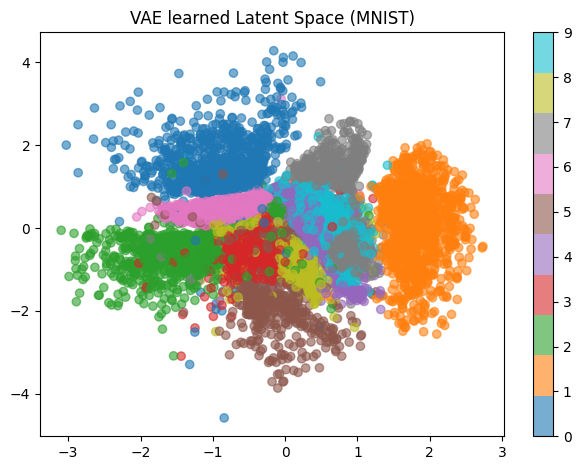

In [9]:
model.eval()
z = []
labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, logvar = model.encoder(x)
        z.append(mu.cpu()) 
        labels.append(y)

z = torch.cat(z)
labels = torch.cat(labels)

plt.Figure(figsize=(8,6))
scatter = plt.scatter(z[:,0], z[:,1], c=labels, cmap='tab10',  alpha=0.6)
plt.colorbar(scatter, ticks=range(10))
plt.title('VAE learned Latent Space (MNIST)')
plt.tight_layout()

plt.show()

In [ ]:
from wesanderson import film_palette

palette_1 = film_palette('Darjeeling Limited', 0)
palette_2 = film_palette('Darjeeling Limited', 1)

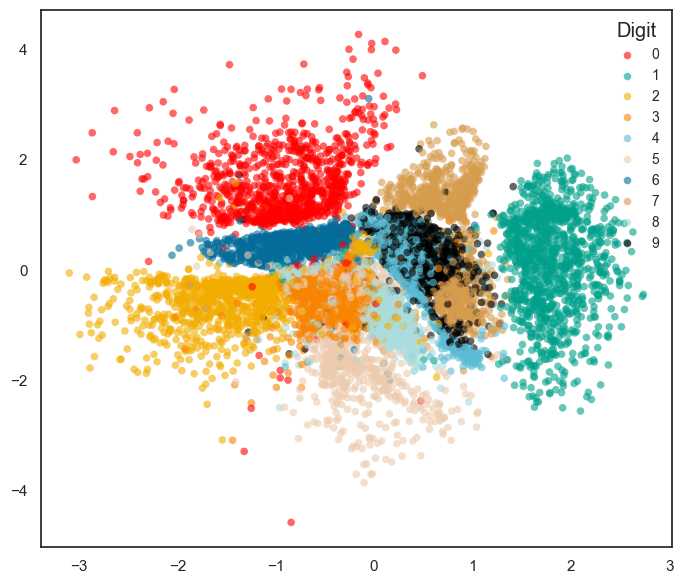

In [12]:
df = pd.DataFrame({
    'z1': z[:,0],
    'z2': z[:,1],
    'label': labels
})

palette = sns.color_palette([*palette_1, *palette_2], len(df['label'].unique()))
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
plt.figure(figsize=(7, 6))

scatter = sns.scatterplot(
    x='z1', y='z2', hue='label', palette=palette, data=df,
    s=30, alpha=0.6, edgecolor='none', linewidth=0
)


plt.xlabel('')
plt.ylabel('')
plt.legend(title='Digit', loc='upper right', frameon=False, fontsize='small', title_fontsize='large')
plt.tight_layout()
plt.show()

In [13]:
def latent2decode(z1, z2, model, device):
    z = torch.tensor([z1, z2]).to(device)
    with torch.no_grad():
        img = model.decoder(z).cpu().view(28,28).numpy()
    return img

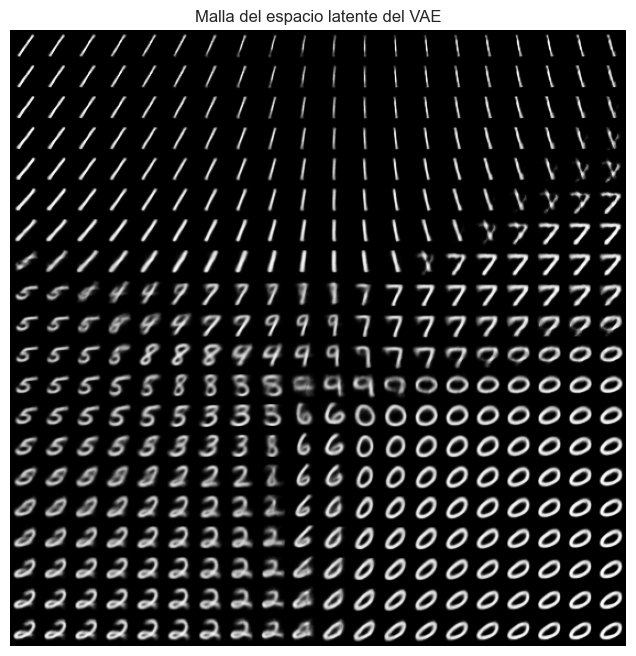

In [14]:
n = 20 # tamaño de la cuadrícula
range_z = 4
z_values = torch.linspace(-3, range_z, n)
image_size = 28

canvas = torch.zeros(image_size * n, image_size * n)

model.eval()
with torch.no_grad():
    for i, z1 in enumerate(z_values):
        for j, z2 in enumerate(z_values):
            z = torch.tensor([[z1, z2]], dtype=torch.float32).to(device)
            x_hat = model.decoder(z).cpu().view(image_size, image_size)
            canvas[(n - i - 1)*image_size:(n - i)*image_size, j*image_size:(j+1)*image_size] = x_hat

plt.figure(figsize=(8, 8))
plt.imshow(canvas, cmap="gray")
plt.axis('off')
plt.title("Malla del espacio latente del VAE")
plt.show()